Project root: C:\Users\gonza\Documents\Conser-vision-Practice-Area-Image-Classification
Raw data directory: C:\Users\gonza\Documents\Conser-vision-Practice-Area-Image-Classification\data\raw
Raw data exists: True

Dataset Overview:
Train features: (16488, 3)
Test features: (4464, 3)
Train labels: (16488, 9)

BASIC DATA INFORMATION

=== TRAIN FEATURES ===
         id                     filepath   site
0  ZJ000000  train_features/ZJ000000.jpg  S0120
1  ZJ000001  train_features/ZJ000001.jpg  S0069
2  ZJ000002  train_features/ZJ000002.jpg  S0009
3  ZJ000003  train_features/ZJ000003.jpg  S0008
4  ZJ000004  train_features/ZJ000004.jpg  S0036

Columns: ['id', 'filepath', 'site']

=== TRAIN LABELS ===
         id  antelope_duiker  bird  blank  civet_genet  hog  leopard  \
0  ZJ000000              0.0   1.0    0.0          0.0  0.0      0.0   
1  ZJ000001              0.0   0.0    0.0          0.0  0.0      0.0   
2  ZJ000002              0.0   1.0    0.0          0.0  0.0      0.0   
3  ZJ000

NameError: name 'project_root' is not defined

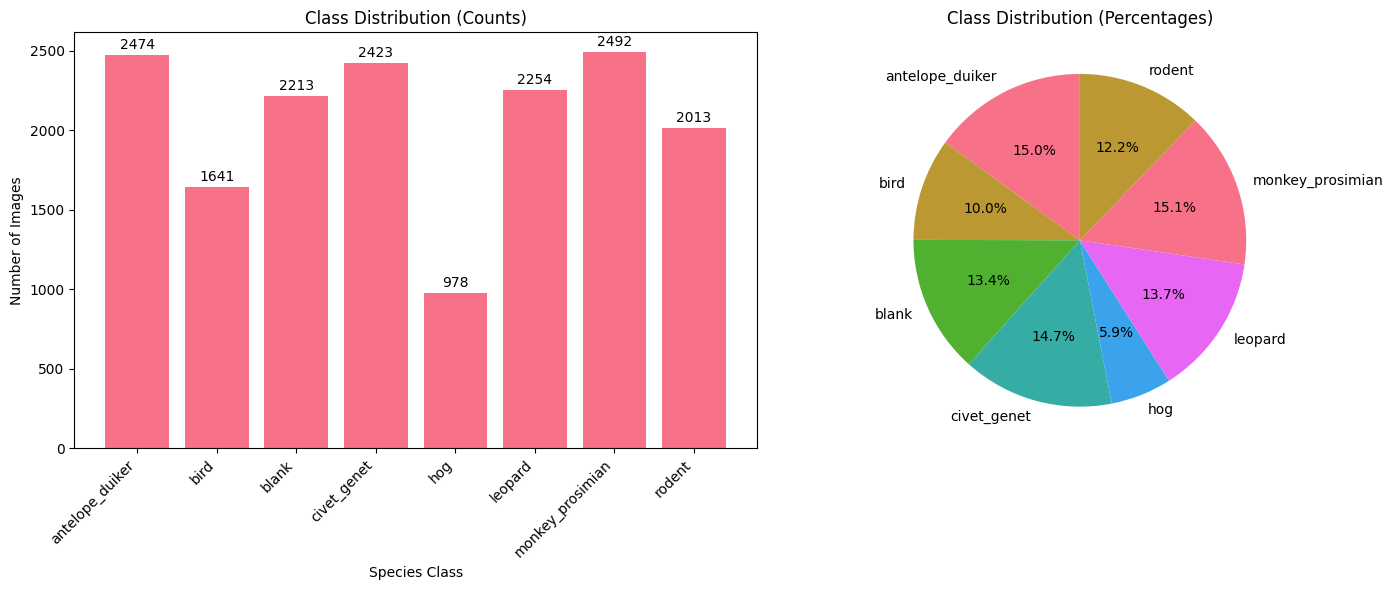

In [3]:
"""
Taï National Park - Data Exploration Script

This script explores the camera trap dataset from Taï National Park to understand:
- Dataset structure and size
- Class distribution
- Site distribution and validation strategy
- Image characteristics
- Data quality and potential issues
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from PIL import Image
from collections import Counter
import warnings
import sys
import os

warnings.filterwarnings('ignore')

def setup_matplotlib():
    """Configure matplotlib for better plots."""
    plt.style.use('default')
    sns.set_palette("husl")
    # Enable interactive mode for showing plots
    plt.ion()

def load_data():
    """Load all dataset files."""
    # Setup paths - handle both root and notebooks directory
    current_dir = Path.cwd()
    if current_dir.name == "notebooks":
        project_root = current_dir.parent
    else:
        project_root = current_dir
    data_raw = project_root / "data" / "raw"
    
    print(f"Project root: {project_root}")
    print(f"Raw data directory: {data_raw}")
    print(f"Raw data exists: {data_raw.exists()}")
    
    # Load metadata files
    train_features = pd.read_csv(data_raw / "train_features.csv")
    test_features = pd.read_csv(data_raw / "test_features.csv")
    train_labels = pd.read_csv(data_raw / "train_labels.csv")
    
    print("\nDataset Overview:")
    print(f"Train features: {train_features.shape}")
    print(f"Test features: {test_features.shape}")
    print(f"Train labels: {train_labels.shape}")
    
    return train_features, test_features, train_labels, data_raw

def basic_data_info(train_features, test_features, train_labels):
    """Display basic information about the datasets."""
    print("\n" + "="*60)
    print("BASIC DATA INFORMATION")
    print("="*60)
    
    print("\n=== TRAIN FEATURES ===")
    print(train_features.head())
    print(f"\nColumns: {train_features.columns.tolist()}")
    
    print("\n=== TRAIN LABELS ===")
    print(train_labels.head())
    print(f"\nColumns: {train_labels.columns.tolist()}")
    
    # Check for missing values
    print("\n=== MISSING VALUES ===")
    print(f"Train features: {train_features.isnull().sum().sum()}")
    print(f"Test features: {test_features.isnull().sum().sum()}")
    print(f"Train labels: {train_labels.isnull().sum().sum()}")
    
    # Data consistency
    print("\n=== DATA CONSISTENCY ===")
    print(f"Unique train IDs: {train_features['id'].nunique()}")
    print(f"Unique test IDs: {test_features['id'].nunique()}")
    print(f"Train features rows: {len(train_features)}")
    print(f"Train labels rows: {len(train_labels)}")
    
    # Check if all train images have labels
    train_ids_set = set(train_features['id'])
    label_ids_set = set(train_labels['id'])
    print(f"All train images have labels: {train_ids_set == label_ids_set}")
    print(f"Missing labels: {len(train_ids_set - label_ids_set)}")
    print(f"Extra labels: {len(label_ids_set - train_ids_set)}")

def analyze_class_distribution(train_labels, project_root):
    """Analyze the distribution of species classes."""
    print("\n" + "="*60)
    print("CLASS DISTRIBUTION ANALYSIS")
    print("="*60)
    
    # Define class names
    class_columns = ['antelope_duiker', 'bird', 'blank', 'civet_genet', 
                     'hog', 'leopard', 'monkey_prosimian', 'rodent']
    
    # Get class distribution
    class_counts = train_labels[class_columns].sum()
    class_percentages = (class_counts / len(train_labels)) * 100
    
    print("\nClass Distribution:")
    print("-" * 45)
    for class_name, count, pct in zip(class_columns, class_counts, class_percentages):
        print(f"{class_name:15}: {int(count):5d} ({pct:5.1f}%)")
    
    # Check for class imbalance
    print(f"\nClass Imbalance Analysis:")
    print(f"Most common class: {class_counts.idxmax()} ({int(class_counts.max())} images)")
    print(f"Least common class: {class_counts.idxmin()} ({int(class_counts.min())} images)")
    print(f"Imbalance ratio: {class_counts.max() / class_counts.min():.2f}:1")
    
    # Visualize class distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar plot
    bars = ax1.bar(range(len(class_columns)), class_counts.values)
    ax1.set_xlabel('Species Class')
    ax1.set_ylabel('Number of Images')
    ax1.set_title('Class Distribution (Counts)')
    ax1.set_xticks(range(len(class_columns)))
    ax1.set_xticklabels(class_columns, rotation=45, ha='right')
    
    # Add count labels on bars
    for i, count in enumerate(class_counts.values):
        ax1.text(i, count + 20, str(int(count)), ha='center', va='bottom')
    
    # Pie chart
    ax2.pie(class_counts.values, labels=class_columns, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Class Distribution (Percentages)')
    
    plt.tight_layout()
    plt.savefig(project_root / 'results' / 'plots' / 'class_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return class_columns, class_counts

def analyze_site_distribution(train_features, test_features, project_root):
    """Analyze the distribution of camera trap sites."""
    print("\n" + "="*60)
    print("SITE DISTRIBUTION ANALYSIS")
    print("="*60)
    
    # Analyze sites in train and test
    train_sites = train_features['site'].value_counts()
    test_sites = test_features['site'].value_counts()
    
    print("Site Analysis:")
    print(f"Number of train sites: {len(train_sites)}")
    print(f"Number of test sites: {len(test_sites)}")
    print(f"Total unique sites: {len(set(train_features['site']) | set(test_features['site']))}")
    
    # Check for site overlap (should be zero according to problem description)
    site_overlap = set(train_features['site']) & set(test_features['site'])
    print(f"Site overlap: {len(site_overlap)} sites")
    if site_overlap:
        print(f"Overlapping sites: {site_overlap}")
    
    # Site statistics
    print(f"\nSite Statistics:")
    print(f"Train sites - Mean images per site: {train_sites.mean():.1f}")
    print(f"Train sites - Median images per site: {train_sites.median():.1f}")
    print(f"Train sites - Min images per site: {train_sites.min()}")
    print(f"Train sites - Max images per site: {train_sites.max()}")
    
    print(f"\nTest sites - Mean images per site: {test_sites.mean():.1f}")
    print(f"Test sites - Median images per site: {test_sites.median():.1f}")
    print(f"Test sites - Min images per site: {test_sites.min()}")
    print(f"Test sites - Max images per site: {test_sites.max()}")
    
    # Visualize site distributions
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    
    # Train sites
    ax1.bar(range(len(train_sites)), train_sites.values)
    ax1.set_title(f'Training Sites Distribution ({len(train_sites)} sites)')
    ax1.set_xlabel('Site Index')
    ax1.set_ylabel('Number of Images')
    
    # Test sites
    ax2.bar(range(len(test_sites)), test_sites.values)
    ax2.set_title(f'Test Sites Distribution ({len(test_sites)} sites)')
    ax2.set_xlabel('Site Index')
    ax2.set_ylabel('Number of Images')
    
    # Combined histogram
    all_train_counts = train_sites.values
    all_test_counts = test_sites.values
    
    ax3.hist([all_train_counts, all_test_counts], bins=20, alpha=0.7, 
             label=['Train sites', 'Test sites'], edgecolor='black')
    ax3.set_xlabel('Images per Site')
    ax3.set_ylabel('Number of Sites')
    ax3.set_title('Distribution of Images per Site')
    ax3.legend()
    
    plt.tight_layout()
    plt.savefig(project_root / 'results' / 'plots' / 'site_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return train_sites, test_sites

def analyze_image_properties(data_raw, train_features, project_root, sample_size=100):
    """Analyze properties of a sample of images."""
    print("\n" + "="*60)
    print("IMAGE PROPERTIES ANALYSIS")
    print("="*60)
    
    # Get image paths
    train_image_paths = [data_raw / path for path in train_features['filepath']]
    
    # Check if images exist
    existing_train_paths = [p for p in train_image_paths if p.exists()]
    
    print(f"Train images found: {len(existing_train_paths)} / {len(train_image_paths)}")
    
    if not existing_train_paths:
        print("No images found! Please check that images are in the correct directory.")
        return None
    
    # Sample images for analysis
    np.random.seed(42)
    sample_paths = np.random.choice(existing_train_paths, 
                                  min(sample_size, len(existing_train_paths)), 
                                  replace=False)
    
    properties = {
        'widths': [],
        'heights': [],
        'channels': [],
        'file_sizes': []
    }
    
    valid_images = 0
    for img_path in sample_paths:
        try:
            # Using PIL for basic info
            with Image.open(img_path) as img:
                width, height = img.size
                channels = len(img.getbands())
                
                properties['widths'].append(width)
                properties['heights'].append(height)
                properties['channels'].append(channels)
                properties['file_sizes'].append(Path(img_path).stat().st_size / 1024)  # KB
                valid_images += 1
                
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    
    if valid_images == 0:
        print("No valid images could be processed!")
        return None
    
    print(f"\nImage Properties (sample of {valid_images} images):")
    print(f"Width - Mean: {np.mean(properties['widths']):.0f}, Range: {min(properties['widths'])}-{max(properties['widths'])}")
    print(f"Height - Mean: {np.mean(properties['heights']):.0f}, Range: {min(properties['heights'])}-{max(properties['heights'])}")
    print(f"Channels - Unique values: {set(properties['channels'])}")
    print(f"File size - Mean: {np.mean(properties['file_sizes']):.1f} KB, Range: {min(properties['file_sizes']):.1f}-{max(properties['file_sizes']):.1f}")
    
    # Visualize image properties
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    axes[0,0].hist(properties['widths'], bins=20, alpha=0.7, edgecolor='black')
    axes[0,0].set_title('Image Widths')
    axes[0,0].set_xlabel('Width (pixels)')
    
    axes[0,1].hist(properties['heights'], bins=20, alpha=0.7, edgecolor='black')
    axes[0,1].set_title('Image Heights')
    axes[0,1].set_xlabel('Height (pixels)')
    
    axes[1,0].scatter(properties['widths'], properties['heights'], alpha=0.6)
    axes[1,0].set_title('Width vs Height')
    axes[1,0].set_xlabel('Width (pixels)')
    axes[1,0].set_ylabel('Height (pixels)')
    
    axes[1,1].hist(properties['file_sizes'], bins=20, alpha=0.7, edgecolor='black')
    axes[1,1].set_title('File Sizes')
    axes[1,1].set_xlabel('Size (KB)')
    
    plt.tight_layout()
    plt.savefig(project_root / 'results' / 'plots' / 'image_properties.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return properties

def analyze_validation_strategy(train_features, train_labels, class_columns):
    """Analyze potential validation strategies based on sites."""
    print("\n" + "="*60)
    print("VALIDATION STRATEGY ANALYSIS")
    print("="*60)
    
    # Random site split
    np.random.seed(42)
    train_site_list = list(train_features['site'].unique())
    np.random.shuffle(train_site_list)
    
    val_ratio = 0.2
    val_sites_count = int(len(train_site_list) * val_ratio)
    val_sites = train_site_list[:val_sites_count]
    train_sites_split = train_site_list[val_sites_count:]
    
    print(f"Random Site Split (80/20):")
    print(f"Total train sites: {len(train_site_list)}")
    print(f"Validation sites: {len(val_sites)}")
    print(f"Training sites: {len(train_sites_split)}")
    
    # Calculate resulting data split
    val_images = train_features[train_features['site'].isin(val_sites)]
    train_images_split = train_features[train_features['site'].isin(train_sites_split)]
    
    print(f"Validation images: {len(val_images)} ({len(val_images)/len(train_features)*100:.1f}%)")
    print(f"Training images: {len(train_images_split)} ({len(train_images_split)/len(train_features)*100:.1f}%)")
    
    # Check class distribution in validation split
    val_labels = train_labels[train_labels['id'].isin(val_images['id'])]
    train_labels_split = train_labels[train_labels['id'].isin(train_images_split['id'])]
    
    val_class_dist = val_labels[class_columns].sum()
    train_class_dist = train_labels_split[class_columns].sum()
    
    print(f"\nClass distribution comparison:")
    print("Class".ljust(15), "Train".rjust(8), "Val".rjust(8), "Val%".rjust(8))
    print("-" * 45)
    for cls in class_columns:
        train_count = int(train_class_dist[cls])
        val_count = int(val_class_dist[cls])
        val_pct = val_count / (train_count + val_count) * 100 if (train_count + val_count) > 0 else 0
        print(f"{cls:15} {train_count:8d} {val_count:8d} {val_pct:7.1f}%")
    
    return val_sites, train_sites_split

def show_sample_images(data_raw, train_features, train_labels, class_name, project_root, n_samples=3):
    """Show sample images for a given class."""
    print(f"\nSample images for {class_name}:")
    
    # Get images for this class
    class_labels = train_labels[train_labels[class_name] == 1]
    
    if len(class_labels) == 0:
        print(f"No images found for class {class_name}")
        return
    
    sample_ids = class_labels['id'].sample(min(n_samples, len(class_labels)), random_state=42)
    
    fig, axes = plt.subplots(1, len(sample_ids), figsize=(4*len(sample_ids), 4))
    if len(sample_ids) == 1:
        axes = [axes]
    
    for i, img_id in enumerate(sample_ids):
        img_info = train_features[train_features['id'] == img_id].iloc[0]
        img_path = data_raw / img_info['filepath']
        
        if img_path.exists():
            try:
                img = Image.open(img_path)
                axes[i].imshow(img)
                axes[i].set_title(f"{img_id}\nSite: {img_info['site']}")
                axes[i].axis('off')
            except Exception as e:
                axes[i].text(0.5, 0.5, f"Error loading\n{img_id}", 
                           ha='center', va='center', transform=axes[i].transAxes)
                axes[i].set_title(f"Error: {img_id}")
        else:
            axes[i].text(0.5, 0.5, f"Image not found\n{img_id}", 
                       ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f"Missing: {img_id}")
    
    plt.suptitle(f"Sample images: {class_name}", fontsize=16)
    plt.tight_layout()
    plt.savefig(project_root / 'results' / 'plots' / f'samples_{class_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

def print_summary(train_features, test_features, class_counts, train_sites, test_sites, image_props=None):
    """Print final summary and recommendations."""
    print("\n" + "="*60)
    print("DATASET SUMMARY AND RECOMMENDATIONS")
    print("="*60)
    
    print(f"\n📊 DATASET SIZE:")
    print(f"  • Training images: {len(train_features):,}")
    print(f"  • Test images: {len(test_features):,}")
    print(f"  • Total images: {len(train_features) + len(test_features):,}")
    
    print(f"\n🏷️ CLASSES:")
    print(f"  • Number of classes: {len(class_counts)}")
    print(f"  • Most common: {class_counts.idxmax()} ({int(class_counts.max()):,} images)")
    print(f"  • Least common: {class_counts.idxmin()} ({int(class_counts.min()):,} images)")
    print(f"  • Imbalance ratio: {class_counts.max() / class_counts.min():.1f}:1")
    
    print(f"\n🌍 SITES:")
    print(f"  • Training sites: {len(train_sites)}")
    print(f"  • Test sites: {len(test_sites)}")
    print(f"  • No overlap between train/test sites: ✓")
    print(f"  • Average images per train site: {train_sites.mean():.1f}")
    
    if image_props:
        print(f"\n🖼️ IMAGES:")
        print(f"  • Average size: {np.mean(image_props['widths']):.0f}x{np.mean(image_props['heights']):.0f} pixels")
        print(f"  • Channels: {set(image_props['channels'])}")
        print(f"  • Average file size: {np.mean(image_props['file_sizes']):.1f} KB")
    
    print(f"\n💡 RECOMMENDATIONS:")
    print(f"  1. Use site-based train/validation split (no site overlap)")
    print(f"  2. Apply class weights to handle imbalance")
    print(f"  3. Use strong data augmentation (rotation, flip, color jitter)")
    print(f"  4. Consider ensemble of models")
    print(f"  5. Resize images to 224x224 or 384x384 for efficiency")
    print(f"  6. Use pretrained models (ResNet, EfficientNet, etc.)")
    print(f"  7. Monitor both overall and per-class performance")
    
    print(f"\n✅ READY FOR IMPLEMENTATION!")

def main():
    """Main function to run the complete data exploration."""
    # Setup paths - handle both root and notebooks directory
    current_dir = Path.cwd()
    if current_dir.name == "notebooks":
        project_root = current_dir.parent
    else:
        project_root = current_dir
    
    # Create necessary directories
    (project_root / "results" / "plots").mkdir(parents=True, exist_ok=True)
    (project_root / "data" / "processed").mkdir(parents=True, exist_ok=True)
    
    # Setup
    setup_matplotlib()
    
    # Load data
    train_features, test_features, train_labels, data_raw = load_data()
    
    # Basic information
    basic_data_info(train_features, test_features, train_labels)
    
    # Class distribution
    class_columns, class_counts = analyze_class_distribution(train_labels, project_root)
    
    # Site distribution
    train_sites, test_sites = analyze_site_distribution(train_features, test_features, project_root)
    
    # Image properties
    image_props = analyze_image_properties(data_raw, train_features, project_root)
    
    # Validation strategy
    val_sites, train_sites_split = analyze_validation_strategy(train_features, train_labels, class_columns)
    
    # Sample images (only if images exist)
    if image_props:
        print(f"\n" + "="*60)
        print("SAMPLE IMAGES")
        print("="*60)
        for class_name in class_columns[:3]:  # Show samples for first 3 classes
            if class_counts[class_name] > 0:
                show_sample_images(data_raw, train_features, train_labels, class_name, project_root)
    
    # Final summary
    print_summary(train_features, test_features, class_counts, train_sites, test_sites, image_props)
    
    # Save validation sites for later use
    val_sites_df = pd.DataFrame({'site': val_sites})
    val_sites_path = project_root / "data" / "processed" / "validation_sites.csv"
    val_sites_df.to_csv(val_sites_path, index=False)
    print(f"\n💾 Validation sites saved to: {val_sites_path}")

if __name__ == "__main__":
    main()